In [1]:
#импорт разного
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D,AveragePooling2D,Conv2DTranspose, Input, Concatenate, Add, BatchNormalization, Activation, MultiHeadAttention
import tensorflow_hub as hub
import tensorflow_text as text
from ipywidgets import IntProgress
from IPython.display import display

In [ ]:
#если нужно что-то разархивировать. 
import zipfile
with zipfile.ZipFile("8k_128.zip", 'r') as zip_ref:
    zip_ref.extractall("8k")

In [ ]:
#загрузка для формата данных из flickr8k. Тоже можно сделать tfrecord, но обрабатывается и так достаточно быстро

import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img

img_dir = "8k/8k_128"
text_file = "captions.txt"

captions = {}
with open(text_file, "r") as f:
    for line in f:
        line = line.strip()
        img_filename, caption = line.split(",", 1)
        img_filename = os.path.join(img_dir, img_filename)
        if img_filename not in captions:
            captions[img_filename] = []
        if  len(captions[img_filename]) ==0:   
            captions[img_filename].append(caption)


img_filenames = list(captions.keys())
img_captions = list(captions.values())

def preprocess_image(img_filename):
    img = tf.io.read_file(img_filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (64, 64), method='area')
    img = tf.cast(img, tf.float32) / 127.5 -1
    return img

img_dataset = tf.data.Dataset.from_tensor_slices(img_filenames)
img_dataset = img_dataset.map(lambda x: (preprocess_image(x)))

caption_dataset = tf.data.Dataset.from_tensor_slices(img_captions)

dataset = tf.data.Dataset.zip((img_dataset, caption_dataset))

def preprocess_caption(caption):
    
    caption = tf.strings.regex_replace(caption, "<.*?>", "")
    caption = tf.strings.lower(caption)
    emb = process_text(caption)
    
    return emb

def nothing(x):
    return x

dataset = dataset.map(lambda x, y: (nothing(x), preprocess_caption(y)))

batch_size = 64
buffer_size = 1000

dataset = dataset.shuffle(buffer_size)
dataset = dataset.batch(batch_size)

AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [2]:
#bert и все, что с ним связано
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

def process_text(text_batch):
    text_preprocessed = bert_preprocess_model(text_batch)
    bert_results = bert_model(text_preprocessed)
    return bert_results["pooled_output"]

In [ ]:
#загрузка датасета coco из tfrecord-а. 
dataset = tf.data.TFRecordDataset('dataset_8.tfrecord')

def parse_record(record):
    feature_description = {
        'a': tf.io.FixedLenFeature([], tf.string),
        'b': tf.io.FixedLenFeature([], tf.string),
        'c': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_record = tf.io.parse_single_example(record, feature_description)
    
    a = tf.io.parse_tensor(parsed_record['a'], out_type=tf.float32)
    b = tf.io.parse_tensor(parsed_record['b'], out_type=tf.float32)
    c = tf.io.parse_tensor(parsed_record['c'], out_type=tf.string)
    
    return a, b, c

dataset = dataset.map(parse_record)

#для данной нейронки лучше, чтобы пиксели находились в пределах [-1...1], а не [0...1]
def modify(a, b, c):
    a = a*2 - 1
    return a, b, c

dataset = dataset.map(modify)
dataset = dataset.shuffle(10).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [2]:
#подробнее о том, что тут происходит: https://keras.io/examples/generative/ddpm/
class GaussianDiffusion:
    """Утилита для гауссовского диффузии.

    Args:
        beta_start: Начальное значение дисперсии
        beta_end: Конечное значение дисперсии
        timesteps: Количество временных шагов в процессе прямой, а затем обратной диффузии
    """

    def __init__(
        self, beta_start=1e-4, beta_end=0.02, timesteps=1000, clip_min=-1.0, clip_max=1.0):
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.timesteps = timesteps
        self.clip_min = clip_min
        self.clip_max = clip_max

        # Определение линейного пространства дисперсии
        self.betas = betas = np.linspace(
            beta_start,
            beta_end,
            timesteps,
            dtype=np.float64,  # Тут используется float64 для лучшей точности
        )
        self.num_timesteps = int(timesteps)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.betas = tf.constant(betas, dtype=tf.float32)
        self.alphas_cumprod = tf.constant(alphas_cumprod, dtype=tf.float32)
        self.alphas_cumprod_prev = tf.constant(alphas_cumprod_prev, dtype=tf.float32)

        # Расчеты для диффузии q(x_t | x_{t-1}) и других
        self.sqrt_alphas_cumprod = tf.constant(np.sqrt(alphas_cumprod), dtype=tf.float32)

        self.sqrt_one_minus_alphas_cumprod = tf.constant(np.sqrt(1.0 - alphas_cumprod), dtype=tf.float32)

        self.log_one_minus_alphas_cumprod = tf.constant(np.log(1.0 - alphas_cumprod), dtype=tf.float32)

        self.sqrt_recip_alphas_cumprod = tf.constant(np.sqrt(1.0 / alphas_cumprod), dtype=tf.float32)
        self.sqrt_recipm1_alphas_cumprod = tf.constant(np.sqrt(1.0 / alphas_cumprod - 1), dtype=tf.float32)

        # Расчеты для апостериорной q(x_{t-1} | x_t, x_0)
        posterior_variance = (betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod))
        self.posterior_variance = tf.constant(posterior_variance, dtype=tf.float32)

        # Обрезка расчета логарифма, так как апостериорная дисперсия равна 0 в начале цепочки диффузии
        self.posterior_log_variance_clipped = tf.constant(np.log(np.maximum(posterior_variance, 1e-20)), dtype=tf.float32)

        self.posterior_mean_coef1 = tf.constant(betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod),dtype=tf.float32,)

        self.posterior_mean_coef2 = tf.constant(
            (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod),dtype=tf.float32)

    def _extract(self, a, t, x_shape):
        """Извлекает некоторые коэффициенты в указанных временных шагах,
        затем изменяет форму на [batch_size, 1, 1, 1, 1, ...] совпадения форм.

        Args:
            a: Тензор для извлечения
            t: Временной шаг, для которого коэффициенты должны быть извлечены
            x_shape: Форма текущих выборок в батче
        """
        batch_size = x_shape[0]
        out = tf.gather(a, t)
        return tf.reshape(out, [batch_size, 1, 1, 1])

    def q_mean_variance(self, x_start, t):
        """Извлекает среднее значение и дисперсию на текущем временном шаге.

        Args:
            x_start: Начальный образец (перед первым шагом диффузии)
            t: Текущий временной шаг
        """
        x_start_shape = tf.shape(x_start)
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start_shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start_shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start_shape)
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise):
        """Диффузия данных.

        Args:
            x_start: Начальный образец (перед первым шагом диффузии)
            t: Текущий временной шаг
            noise: Добавляемый гауссовский шум на текущем временном шаге
        Returns:
            Диффузионные образцы на временном шаге `t`
        """
        x_start_shape = tf.shape(x_start)
        
        return (
            self._extract(self.sqrt_alphas_cumprod, t, tf.shape(x_start)) * x_start
            + self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start_shape)
            * noise
        )

    def predict_start_from_noise(self, x_t, t, noise):
        x_t_shape = tf.shape(x_t)
        
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t_shape) * x_t
            - self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t_shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        """Вычисляет среднее значение и дисперсию диффузии апостериорной q(x_{t-1} | x_t, x_0).

        Args:
            x_start: Точка начала (образец) для вычисления апостериори
            x_t: Образец на временном шаге `t`
            t: Текущий временной шаг
        Returns:
            Апостериорное среднее значение и дисперсия на текущем временном шаге
        """

        x_t_shape = tf.shape(x_t)
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t_shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t_shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t_shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t_shape)
        
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, pred_noise, x, t, clip_denoised=True):
        x_recon = self.predict_start_from_noise(x, t=t, noise=pred_noise)
        if clip_denoised:
            x_recon = tf.clip_by_value(x_recon, self.clip_min, self.clip_max)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start=x_recon, x_t=x, t=t)
        
        return model_mean, posterior_variance, posterior_log_variance

    def p_sample(self, pred_noise, x, t, clip_denoised=True):
        """Выборка из модели диффузии.

        Args:
            pred_noise: Шум, предсказанный моделью диффузии
            x: Образцы на определенном временном шаге, для которого был предсказан шум
            t: Текущий временной шаг
            clip_denoised (bool): Нужно ли обрезать предсказанный шум в указанном диапазоне или нет.
        """
        model_mean, _, model_log_variance = self.p_mean_variance(pred_noise, x=x, t=t, clip_denoised=clip_denoised)
        noise = tf.random.normal(shape=x.shape, dtype=x.dtype)
        # Нет шума, когда t == 0
        nonzero_mask = tf.reshape(1 - tf.cast(tf.equal(t, 0), tf.float32), [tf.shape(x)[0], 1, 1, 1])
        
        return model_mean + nonzero_mask * tf.exp(0.5 * model_log_variance) * noise


In [3]:
embedding_dims = 32
embedding_max_frequency = 1000.0

def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

#код сборки нейросети

#основной "вычислительный" блок, на них приходится большинство параметров
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation=keras.activations.swish)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

#понижающий блок
def DownBlock(width, block_depth):
    width, att = width
    def apply(x):
        x, skips, emb, annotation_embedding = x
        height = x.shape[1]
        if att:
            
            #тут подключается текстовый эмбеддинг
            t_emb = layers.UpSampling2D(size=height, interpolation="nearest")(annotation_embedding)
            x_att = Concatenate()([x, t_emb])
            x = MultiHeadAttention(key_dim=128, num_heads = 16)(x, x_att, x_att)
            
        e = layers.UpSampling2D(size=height, interpolation="nearest")(emb)
        x = Concatenate()([x, e])
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply

#повышающий блок
def UpBlock(width, block_depth):
    width, att = width
    def apply(x):
        x, skips, annotation_embedding = x
        
        height = x.shape[1]
        if att:
            
            #тут подключается текстовый эмбеддинг
            t_emb = layers.UpSampling2D(size=height, interpolation="nearest")(annotation_embedding)
            x_att = Concatenate()([x, t_emb])
            x = MultiHeadAttention(key_dim=128, num_heads = 16)(x, x_att, x_att)
            
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances_r = keras.Input(shape=(1,1,1))
    annotation_embedding = keras.Input(shape=(1, 1, 512))
    
    x = noisy_images
    emb = layers.Lambda(sinusoidal_embedding)(noise_variances_r)

    skips = []
    
    #сборка нейросети U-net автоматическая. Имеет смысл менять только кол-во блоков и
    #архитектуру основного блока. Остальное код сделает за нас)
    
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips, emb, annotation_embedding])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1][0])(x)
        
    #текстовый эмбеддинг в центральной части модели
    t_emb = layers.UpSampling2D(size=4, interpolation="nearest")(annotation_embedding)
    x_att = Concatenate()([x, t_emb])
    x = MultiHeadAttention(key_dim=128, num_heads = 16)(x, x_att, x_att)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips, annotation_embedding])
        
    #для лучшей четкости картинки 
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(emb)
    x = layers.Concatenate()([x, noisy_images, e])
    x = layers.Conv2D(32, kernel_size=1, padding = 'same', activation=keras.activations.swish )(x)

    x = layers.Conv2D(3, kernel_size=1,  kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances_r, annotation_embedding], x, name="residual_unet")

In [4]:
class DiffusionModel(keras.Model):
    def __init__(self, network, ema_network, timesteps, gdf_util, ema=0.999):
        super().__init__()
        
        #используем технологию ema network - бегущее среднее для всех весов нейросети.
        #никак не влияет на обучаемую модель, но в процессе обучения обновляет веса ema модели.
        #в результате используем именно ema модель. Это стабилизирует результат, чинит любые шумы, "перекосы цветов" и т.д.
        self.network = network
        self.ema_network = ema_network
        self.timesteps = timesteps
        self.gdf_util = gdf_util
        self.ema = ema
        self.lr = 1e-4
        self.optimizer = tf.keras.optimizers.Adam(self.lr)
    @tf.function
    def train_step(self, images, annotations):
        # 1. Найдем размер батча
        batch_size = tf.shape(images)[0]

        # 2. Получим случайные значечения временных шагов
        t = tf.random.uniform(minval=0, maxval=self.timesteps, shape=(batch_size,), dtype=tf.int64)

        with tf.GradientTape() as tape:
            # 3. Получим случайный шум. Его и будем добавлять к картинке
            noise = tf.random.normal(shape=tf.shape(images), dtype=images.dtype)

            # 4. Применяем шум по правилам гауссовской диффузии
            images_t = self.gdf_util.q_sample(images, t, noise)

            # 5. Пропустим зашумленное изображение через нейросеть
            pred_noise = self.network([images_t, tf.reshape(t, shape = (-1, 1,1,1)), tf.reshape(annotations, shape = (-1, 1,1,512))], training=True)

            # 6. Расчитаем ошибку
            loss = tf.reduce_mean((noise - pred_noise)**2, axis = (1,2,3))

        # 7. Расчитаем градиенты
        gradients = tape.gradient(loss, self.network.trainable_weights)

        # 8. Обновим веса нейросети
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        # 9. Обновим веса EMA сети
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)

        # 10. Return loss values
        return loss

    def generate_images(self, num_images=16, annotation = " "):
        
        # 0. Преобразуем текст в эмбеддинг
        annotation = tf.expand_dims(annotation, axis = 0)
        embedding = process_text(annotation)
        embedding = tf.expand_dims(embedding, axis = 0)
        embeddings = tf.repeat(embedding, num_images , axis = 0)
        
        # 1. Берем случайный шум
        samples = tf.random.normal(shape=(num_images, image_size, image_size, img_channels), dtype=tf.float32)
        
        # 2. Применяем к нему нейросеть (не ту, что обучали напрямую, а EMA) несколько раз
        bar = IntProgress(min=0, max=self.timesteps) #прогресс-бар
        display(bar)
        for t in reversed(range(0, self.timesteps)):
            bar.value+=1
            tt = tf.cast(tf.fill(num_images, t), dtype=tf.int64)
            pred_noise = self.ema_network.predict([samples, tf.reshape(tt, shape = (-1, 1,1,1)), tf.reshape(embeddings, shape = (-1, 1,1,512))], verbose=0, batch_size=num_images)
            samples = self.gdf_util.p_sample(pred_noise, samples, tt, clip_denoised=True)

        return samples

    def plot_images(self, epoch=None, logs=None, num_rows=2, num_cols=8, figsize=(12, 5), annotation = " "):
        
        generated_samples = self.generate_images(num_images=num_rows * num_cols, annotation = annotation)
        generated_samples = (tf.clip_by_value(generated_samples * 127 + 127, 0.0, 255.0).numpy().astype(np.uint8))

        _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
        for i, image in enumerate(generated_samples):
            if num_rows == 1:
                ax[i].imshow(image)
                ax[i].axis("off")
            else:
                ax[i // num_cols, i % num_cols].imshow(image)
                ax[i // num_cols, i % num_cols].axis("off")

        plt.tight_layout()
        plt.show()

In [5]:
#можно попробовать от 300 до 1000 (больше - лучше, но дольше генерация)
total_timesteps = 500

widths = [[64, False], [96, False], [128, False], [256, False], [256, False]]

block_depth = 2

batch_size = 64

img_channels = 3
clip_min = -1.0
clip_max = 1.0

image_size = 64


network = get_network(
    image_size=image_size,
    widths=widths,
    block_depth = block_depth
)
ema_network = get_network(
    image_size=image_size,
    widths=widths,
    block_depth = block_depth
)
ema_network.set_weights(network.get_weights())  # изначально веса равны

gdf_util = GaussianDiffusion(timesteps=total_timesteps)

model = DiffusionModel(network=network, ema_network=ema_network, gdf_util=gdf_util, timesteps=total_timesteps)

In [ ]:
#обучаем
epochs = 500
hist = np.array(np.empty([0]))
from IPython.display import clear_output
for epoch in range(epochs):
    midloss = 0
    for step, x in enumerate(dataset):
        a, b = x
        if tf.shape(a)[0] == batch_size: #проверяем целостность батча
            midloss += tf.reduce_mean(model.train_step(a, b), axis = 0)

        if(step == 10):  
            clear_output(wait=True)
            print('эпоха ' + str(epoch))
            print('ошибка: ' + str(float(midloss/10)))
           
            hist = np.append(hist, float(midloss/10))
            plt.plot(np.arange(0,len(hist)), hist)
            plt.show()

IntProgress(value=0, max=500)

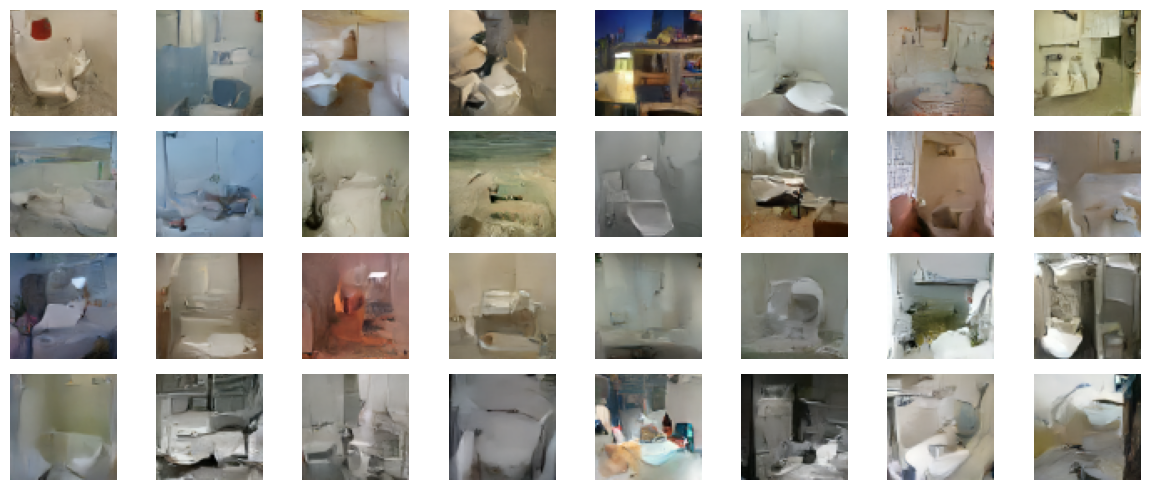

IntProgress(value=0, max=500)

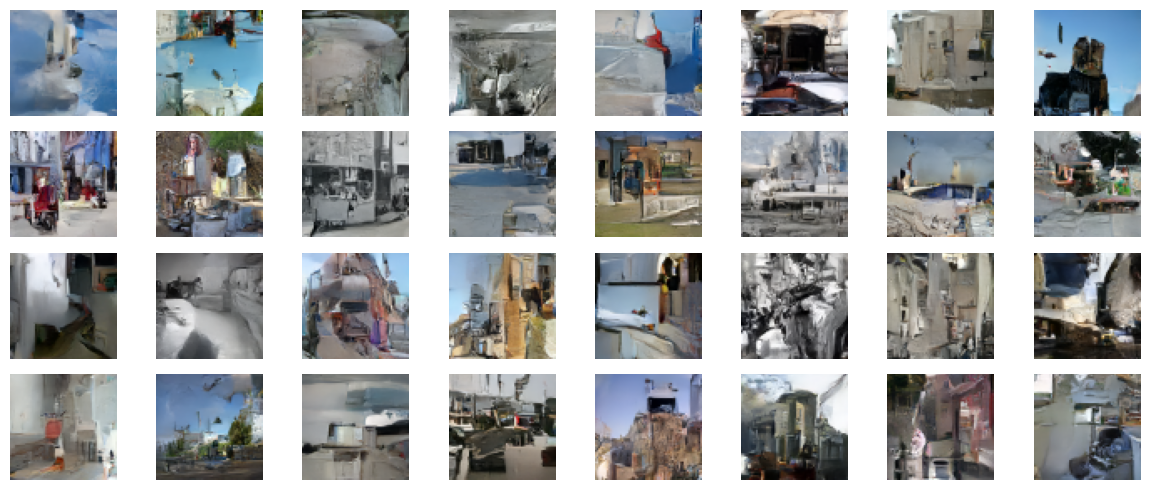

In [18]:
model.plot_images(num_rows=4, num_cols=8, annotation = "A blue bathroom with a toilet")
model.plot_images(num_rows=4, num_cols=8, annotation = "Big clock on the building")

In [9]:
model.ema_network.save("kt_diffision_v2.1.h5")

In [ ]:
model.network.summary()

In [8]:
model.ema_network.load_weights("kt_diffision_v2.1.h5")